In [1]:
# Set up environment with correct dependencies
using Pkg
Pkg.activate(".")
Pkg.instantiate()

 Activating environment at `~/GitHub/MathSys/teaching/MA934/MA934-slides/Project.toml`


In [2]:
using Plots
using LaTeXStrings
using Revise
pyplot()
# Set default fonts for all plots
fnt = Plots.font("DejaVu Sans", 8.0)
default(titlefont=fnt, guidefont=fnt, tickfont=fnt, legendfont=fnt)

function plotconvex()
    x = 0:0.01:2.0
    X=0.25;Y=1.75
    f(x) = x^3.0
    lambda = 0:0.01:1
    x2 = [l*X + (1-l)*Y for l in lambda]
    y2 = [l*f(X) + (1-l)*f(Y) for l in lambda]
    y = f.(x)
    p = plot(x,y, label=L"f(\lambda\,x + (1-\lambda)\,y)", linewidth=3)
    plot!(x2,y2, label=L"\lambda\, f(x) + (1-\lambda)\,f(y)", linewidth=3)
    annotate!(0.25, -0.65,text("x", 18))
    annotate!(1.75, -0.65,text("y", 18))
    return p
end


function plotinequalities(F,Xmax, op, lbl, col)
    x = 0.0:0.1:Xmax
    p = plot(xlim=(0,Xmax), ylim=(0,Xmax))
    for i in 1:length(F)
        y = F[i].(x)
        if op[i] == 'L' 
            plot!(x,y,ylim=(0,Xmax),fill=(0, 0.3, col[i]), label = lbl[i]*"<0")
        elseif op[i] == 'G'
            plot!(x,y,ylim=(0,Xmax),fill=(Xmax, 0.3, col[i]), label = lbl[i]*">0")
        else
            error("Error")
        end
    end    
    return p
end
    

function plotcheckloss(tau)
    checkloss(x, tau) = tau*maximum([x,0.0]) + (1.0-tau)*maximum([-x, 0])
    x = -1:0.01:1
    y1 = checkloss.(x, tau)
    p = plot(x,y1, label=L"\tau = "*string(tau), linewidth=3, xlabel="z", ylabel=L"\rho_\tau(z)")
    
    return p
end

plotcheckloss (generic function with 1 method)

## MA934

## Convex optimisation and linear programming

"The subject of linear programming is surrounded by notational and terminological thickets.
 Both of these defenses are lovingly cultivated by a coterie of stern acolytes who have devoted themselves to the field..."
 
         Numerical Recipes, Press et. al.

### Reminder: gradient and Hessian

Given a continuous, differentiable $f: \mathbb{R}^n \to \mathbb{R}$, the *gradient* of $f$ at $\mathbf{x}$ is the vector
$$
\nabla\,f(\mathbf{x}) = \left( 
\begin{array}{c}
\frac{\partial f(\mathbf{x}) }{\partial x_1}\\
\frac{\partial f(\mathbf{x}) }{\partial x_2}\\
\vdots\\
\frac{\partial f(\mathbf{x}) }{\partial x_n}\\
\end{array}
\right).
$$

Given a continuous, twice-differentiable $f: \mathbb{R}^n \to \mathbb{R}$, the  *Hessian* of $f$ at $\mathbf{x}$ is the matrix
$$
H\,f(\mathbf{x}) = \left( 
\begin{array}{ccc}
\frac{\partial^2 f(\mathbf{x}) }{\partial x_1^2}& \ldots & \frac{\partial^2 f(\mathbf{x}) }{\partial x_1 \partial x_n}\\
\ldots & \ldots & \ldots\\
\frac{\partial^2 f(\mathbf{x}) }{\partial x_n \partial x_1} & \ldots & \frac{\partial^2 f(\mathbf{x}) }{\partial x_n^2}
\end{array}
\right),
$$

### Convex sets

$S \subseteq \mathbb{R}^n$ is a *convex set* if for any $x$, $y\in S$, the line segment connecting $x$ and $y$ is contained in $S$. 

That is, for every point $z$,
$$
z = \lambda\, x + (1-\lambda)\,y
$$
with  $x$, $y\in S$ and $\lambda \in [0,1]$, we have $z \in S$. 

Intersection of convex sets is convex.

<img src="files/images/convexset.png" alt="convex set" style="width: 250px;"/> Convex set.

<img src="files/images/nonconvexset.png" alt="nonconvex set" style="width: 250px;"/> Nonconvex set.

### Convex functions

Let $S \subseteq \mathbb{R}^n$ be a convex set and let $f: S \to \mathbb{R}$ be a real-valued function on $S$.

$f$ is a *convex function* over $S$ if for
any $x$, $y \in S$ and $\lambda \in [0,1]$,
$$
f( \lambda\, x + (1-\lambda)\,y) \leq  \lambda\, f(x) + (1-\lambda)\,f(y).
$$

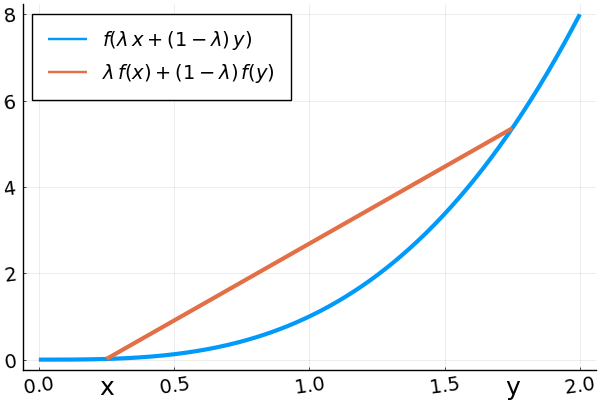

In [3]:
plotconvex()

### Convex functions: alternative characterisation

One can show that if $C \subseteq \mathbb{R}^n$ is a convex set and $f$ is a continuous, differentiable function on  $C$, then $f$ is convex on $C$ if and only if
for all $\mathbf{x}$, $\mathbf{y} \in C$ we have
$$
f(\mathbf{y}) - f(\mathbf{x}) \geq \nabla\,f (\mathbf{x}) \cdot (\mathbf{y} -\mathbf{x}).
$$

Generalises the one-dimensional observation:
$$
\frac{\Delta f}{\Delta x}(x,y) =\frac{f(y)-f(x)}{y-x}  \geq \frac{df}{dx}(x)
$$




### Optimisation

Optimisation is the process of finding maxima and minima of a real-valued function, $f: \mathbb{R}^n \to \mathbb{R}$, referred to as the objective function (cost function, optimand, loss function...) Various flavours:
* local and global
* constrained ($f: C \subseteq \mathbb{R}^n \to \mathbb{R}$) and unconstrained
* convex and non-convex

We will consider all problems to be minimisation problems. 

### Local and global minima

 Consider constrained optimisation problem over a set, $C \subseteq \mathbb{R}^n$:
 $$\min_{\substack{x \in C} }f(x).$$
 
A point $x^* \in C$ is a *global minimum* of $f$ over $C$ if
$$
f(x^*) \leq f(x) \ \ \ \text{for all $x \in C$.}
$$

A point $x^* \in C$ is a *local minimum* of $f$ over $C$ if there exists an $\epsilon$-ball, $B(x^*, \epsilon)$, centred at $x^*$ such that
$$
f(x^*) \leq f(x) \ \ \ \text{for all $x \in C \cap B(x^*, \epsilon)$,}
$$
with $\epsilon > 0$.


### Convex optimisation 

A convex optimisation problem is a problem of the form
$$
\min_{\substack{x \in C} }f(x)
$$
where $C$ is a convex set and $f$ is a convex function on $C$. 

Key result:
> If $C$ is a convex set and $f$ is a convex function on $C$, then every local minimum of $f$ over $C$ is also a global minimum of $f$ over $C$.

### Optimality conditions for convex problems

If $\mathbf{x}^*$ is a local minimum of $f$, then 
$$\nabla\,f(\mathbf{x}^*) = 0.$$
Called *first order optimality conditions*. Necessary but not sufficient: eigenvectors of the Hessian to distinguish minima, maxima and saddles.

However, for a convex function on a convex set $C$, for any $\mathbf{y} \in C$
$$
f(\mathbf{y}) - f(\mathbf{x}^*) \geq \nabla\,f (\mathbf{x}^*) \cdot (\mathbf{y} -\mathbf{x}^*) = 0.
$$
So $f(\mathbf{y}) \geq f(\mathbf{x}^*)$ for all $\mathbf{y} \in C$ and $\mathbf{x}^*$ is a minimum.

For convex optimisation problems, first order optimality conditions are necessary *and* sufficient.


### arg min notation

Given an optimisation problem,
$$
\min_{\substack{x \in C} }f(x)
$$
we will sometimes write the solution as
$$
x^* =  \arg \min_{x \in C} f(x). 
$$

This is shorthand  way of saying that $x^*$ is the value (or set of values) of $x$ that minimises $f(x)$ over the set $C$.

### Linear optimisation in $\mathbb{R}$
Consider minimising $f(x) = 2 x + 1$ with $x \in \mathbb{R}$. Clearly no minimum without constraints.

Some possible constraints:
1. $x \leq 1$ and $x\geq-1$,
2. $x \geq 1$ and $x\leq -1$,
3. $x\leq -1$ and $x \leq -2$.




Outcomes:

1. Solution exists at $x=-1$. 
2. No solution  because the constraints are inconsistent.
3. No solution because the constraints do not prevent $x$ from becoming arbitrarily negative so $f(x)$ is unbounded below.

### Optimisation of linear functions in $\mathbb{R^n}$

Linear programming means optimisation of linear functions on $\mathbb{R}^n$ subject to constraints.

 * $\mathbf{x} = (x_1, x_2,\ldots x_n) \in \mathbb{R}^n$ are called *structural variables*.
 *  $\mathbf{c} = (c_1, c_2,\ldots c_n) \in \mathbb{R}^n$ is called the *costs vector*.
 
 Objective function is
 $$
\begin{align}
f:\ \mathbb{R}^n \to \mathbb{R} : \ \mathbf{x} &\mapsto c_1 x_1 + c_2 x_2 + \ldots + c_nx_n\\
&= \mathbf{c} \cdot \mathbf{x}.
\end{align}
$$
 


### Optimisation of linear functions in $\mathbb{R^n}$: constraints
The task is to minimise or maximise $f(\mathbf{x})$ subject to the $m$ constraints
$$
\begin{align}
 a_{1 1}x_1 + a_{1 2}x_2 + \ldots a_{1 n} x_n &\sim b_1\\
a_{2 1}x_1 + a_{2 2}x_2 + \ldots a_{2 n} x_n &\sim b_2\\
\vdots \hspace{3.0cm} &\vdots\\
a_{m 1}x_1 + a_{m 2}x_2 + \ldots a_{m n} x_n &\sim b_m,
\end{align}
$$
(where $\sim$ can mean $\geq$, $\leq$ or $=$)
*and* $n$ *positivity conditions* on the structural variables,  
$$
x_1 \geq 0,\ x_2 \geq 0, \ldots x_n\geq 0, 
$$
There are $m+n$ constraints in total.

### Feasible set

$\mathbf{x}$ is a *feasible* vector if it satisfies the constraints.

The set of all feasible vectors is called the *feasible set*.
A feasible vector, $\mathbf{x}^*$, is said to be *optimal* if it minimises the objective function.

There are 3 possibiliities:
* an optimal feasible vector exists and the problem is said to be solvable,
* there are no feasible vectors and the problem is said to be infeasible
* feasible vectors exist but there is no minimum and the problem is said to be unbounded.



### Constraints in $\mathbb{R}^2$

Sometimes easier to visualise the complement of the feasible set.

In [4]:
f1(x) = 50.0 - 2.0*x
f2(x) = 30.0 - x/3.0
f3(x) = 45.0 - 3.0*x
f4(x) = 13.0 - x/3.0
lbls = [L"50-2x", L"30-\frac{x}{3}", L"45 - 3x", L"13 - \frac{x}{3}"]
cols = [:blue, :red, :green, :purple]

4-element Array{Symbol,1}:
 :blue
 :red
 :green
 :purple

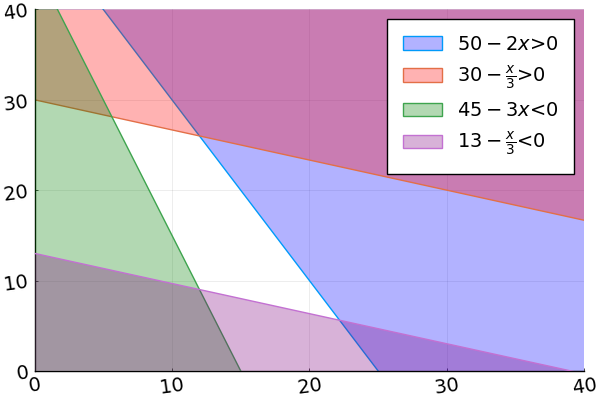

In [5]:
plotinequalities([f1, f2, f3, f4], 40.0,['G','G','L', 'L'], lbls, cols)

### Linear programming is a convex optimisation problem

* Each equality constraint restricts the feasible set to a hyperplane of dimension n − 1 in $\mathbb{R}^n$.
* Each inequality constraint defines a hyperplane dividing $\mathbb{R}^n$ into an allowed and non-allowed half-space. 
* The feasible set is an intersection of convex sets and is thus convex (a polyhedron in $\mathbb{R}^n$). 
* f (x) is a convex function on $\mathbb{R}^n$. 
* All linear programming problems are therefore convex optimisation problems.

### Slack variables

An inequality constraint can be converted into an equality constraint by introducing an additional variable called a *slack variable*.

$$
 a_{1}x_1 + a_{2}x_2 + \ldots a_{n} x_n \leq b.
$$
is equivalent to writing an equality involving a new, non-negative slack variable, $s$:
$$
 a_{1}x_1 + a_{2}x_2 + \ldots a_{n} x_n  + s =  b,
$$
with $s \geq 0$. 

The positivity constraint on the slack variable measures the extent to which the original inequality is satisfied.

### Writing a linear program in standard form

Any linear programme can be written in *standard form*  in which the only inequality constraints are the positivity conditions and all remaining constraints are equality constraints. A linear programme is in standard form if it in the form: minimise
$$
f(\mathbf{x}) = \mathbf{c}\cdot\,\mathbf{x} = c_1 x_1 + c_2 x_2 + \dots +c_{n}x_{n},
$$
subject to $m$ $equality$ constraints
$$
A\,\mathbf{x} = \mathbf{b}
$$
and $n$ positivity conditions
$$
\mathbf{x} \geq 0
$$
where $A$ is an $m \times n$ matrix, $\mathbf{b}  \in \mathbb{R}^m$   and $\mathbf{c} \in \mathbb{R}^{n}$  is a cost vector.



### Converting a general linear programme to standard form

1. Convert any $\geq$ constraints to $\leq$ constraints by multiplying by $-1$.
2. For each $\leq$ constraint introduce a new slack variable to convert it into an equality. Equality constraints do not need slack variables. 
3. Equality constraints with a negative right-hand side should be multiplied by -1 so that the right-hand side is positive.
4. Build a new cost vector by padding the initial cost vector with zeros to accommodate the slack variables.

Slack variables are now treated equivalently to the structural variables. 
However since they have zero cost, we can forget about them at the end.


### The solution, $\mathbf{x}^*$, of a solvable LP is at a vertex of the feasible set

The gradient of the objective function, $f(\mathbf{x})$, is nowhere zero in $\mathbb{R}^n$:
$$
\nabla f(\mathbf{x}) = \mathbf{c} \neq 0.
$$
Thus $\mathbf{x}^*$ cannot be in the interior of the feasible set, $S$, and must therefore be on the boundary. 

The boundary of a polyhedron of dimension $d$ is a set of faces which are polyhedra of dimension $d-1$.

Let's refer to the face containing $\mathbf{x}^*$ as $P$.

### The solution, $\mathbf{x}^*$, of a solvable LP is at a vertex of the feasible set

In general, the projection of the gradient of the objective function, $f(\mathbf{x})$, onto the hyperplane containing $P$ is also nowhere zero in that hyperplane.

Thus $\mathbf{x}^*$ cannot be in the interior of $P$, and must be on the boundary. 

Iterating, we conclude that $\mathbf{x}^*$ must be at a *vertex* of the feasible set.

Since vertices are points in $\mathbb{R}^n$, their coordinates must satisfy $n$ of the $n+m$ constraints as **equalities**.

An $\mathbf{x}$ satisfying $n$ constraints as equalities is called a *feasible basic vector*. 

### Fundamental theorem of Linear Programming

> For any LP, if an optimal feasible vector exists then there is a feasible basic vector that is optimal. 

This reduces the original optimisation problem to a finite combinatorial task: 

>  Enumerate all $\binom{n+m}{n} $ feasible basic vectors, evaluate the objective function on each and choose a best one.

This is then guaranteed to be optimal.

Problem: in practice, the number of combinations can be prohibitively large.


### Dantzig Simplex Algorithm

* Dantzig simplex algorithm aims to determine *efficiently* which $n$ constraints from the $n+m$ available constraints are satisfied as equalities by the optimal feasible basic vector.

* Idea: start from any vertex and iteratively move to new vertices so that the objective function always decreases.

* Optimal vertex found when impossible to decrease any further.

### Basic and non-basic variables

For a LP in standard form:

* $m$ components of a basic feasible vector, $\mathbf{x}$, are general non-zero  since $\mathbf{x}$ satisfies the $m$ equality  constraints. These are called *basic variables*.
* The remaining $n-m$ components of $\mathbf{x}$ must be zero since $\mathbf{x}$ must satisfy a subset of of the inequality constraints as equalities. These are called *non-basic variables*.
* Different basic feasible vectors will have different basic and non-basic variables.

### Simplex algorithm: schematic

1. Start with any basic feasible vector, $\mathbf{x}$. 
2. Identify the current non-basic variable, $x_k$, that would produce the largest decrease in the objective, $f(\mathbf{x})$, if it became positive. 
3. Identify the current basic variable, $x_i$, that hits zero first as $x_k$ increases. 
4. Swap $x_i$ for $x_k$ to produce a new basic feasible vector, $\mathbf{x}$ and return to step 2.

To know how to select $x_k$ at step 2 and $x_i$ at step 3 some calculations are needed. 

### Simplex algorithm: termination conditions

How do we know when to stop? 

The algorithm can terminate in two ways:

* At step 2: if none of the current non-basic variables can decrease $f(\mathbf{x})$ by becoming positive, then the current basic feasible vector is optimal.

* At step 3: if there is no basic variable that becomes zero as $x_k$ is increased, the problem is unbounded.

### Simplex algorithm: some notation


Let us denote column $k$ of the matrix $A$ by $\mathbf{a}_k$. Thus we have
$$
A = \left(\mathbf{a}_1 | \mathbf{a}_2 | \ldots | \mathbf{a}_{n+m}\right).
$$
Rearrange the columns of  $\mathbf{x}^T$ so that the basic variables come first:
$$
\mathbf{x}^T = (\mathbf{x}_B\, |\, \mathbf{x}_N).
$$
We must similarly rearrange the columns of $A$ and $\mathbf{c}$:
$$
\begin{align*}
A & = \left( A_B\, |\, A_N\right)\\
\mathbf{c}^T & = \left(\mathbf{c}_B\, | \, \mathbf{c}_N\right).
\end{align*}
$$
Since the non-basic variables are all zero, $\mathbf{x}_B$ satisfies
$$
\begin{align}
  & A_B\,\mathbf{x}_B = \mathbf{b}\\
\Rightarrow &\mathbf{x}_B = A_B^{-1}\,\mathbf{b}.
\end{align}
$$

### Simplex algorithm: selecting the non-basic variable to make basic 

Take a non-basic variable, $x_k$ and increase it away from zero. 
Then $\mathbf{x}_B$ changes to some other value, $\mathbf{x}_B^\prime$. 
Since only $x_k$ among the non-basic variables is not zero, the satisfaction of the constraints requires that
$$
A_B\, \mathbf{x}_B^\prime + x_k\,\mathbf{a}_k = \mathbf{b}.
$$
Solving for $\mathbf{x}_B^\prime$:
$$
\mathbf{x}_B^\prime = A_B^{-1}\,\mathbf{b} - x_k A_B^{-1}\,\mathbf{a}_k.
$$
Using the fact that $\mathbf{x}_B = A_B^{-1}\,\mathbf{b}$ we get
$$
\mathbf{x}_B^\prime = \mathbf{x}_B - x_k A_B^{-1}\,\mathbf{a}_k.
$$
We can now calculate the change in the objective function upon going from $\mathbf{x}_B$ to $\mathbf{x}_B^\prime$

### Simplex algorithm: selecting the non-basic variable to make basic 

Let $\mathbf{e}_k$ be the unit vector in the $k^\text{th}$ coordinate direction in $\mathbb{R}^n$. 

**Before** increasing $x_k$, the objective function is:
$$
f[ \left(\mathbf{x}_B\, | \, \mathbf{x}_N\right)^T] = \mathbf{c}_B^T\,\mathbf{x}_B.
$$
**After** increasing $x_k$ we have
$$
\begin{align}
f[ \left(\mathbf{x}_B^\prime\, | \, \mathbf{x}_N\right) + x_k\mathbf{e}_k] &= \mathbf{c}_B^T\,\mathbf{x}_B^\prime + c_k x_k\\
 & =  \mathbf{c}_B^T \left( \mathbf{x}_B - x_k A_B^{-1}\,\mathbf{a}_k \right) + c_k x_k\\
 &=  \mathbf{c}_B^T\,\mathbf{x}_B - x_k\left( \mathbf{c}_B^T A_B^{-1}\mathbf{a}_k -c_k\right).
\end{align}
$$ 
The **difference** is
$$
(\Delta\,f)_k = x_k\left( c_k - \mathbf{c}_B^T A_B^{-1}\mathbf{a}_k\right).
$$
We choose the non-basic variable, $x_k$, with the **most negative** value of $(\Delta \, f)_k$.

### Simplex algorithm: selecting the basic variable to make non-basic 
We have found above
$$
\mathbf{x}_B^\prime = \mathbf{x}_B - x_k A_B^{-1}\,\mathbf{a}_k.
$$

To simplify notation, write $\mathbf{w} = A_B^{-1}\,\mathbf{a}_k$. The $i^\text{th}$ component of $\mathbf{x}_B^\prime$ is
$$
(x_B^\prime)_i = (x_B)_i - x_k\,w_i.
$$
We see that for each $w_i > 0$, the $i^\text{th}$ component of $\mathbf{x}_B^\prime$ decreases as $x_k$ increases.
Setting $(x_B^\prime)_i =0$ and solving for $x_k$ we get
$$
x_k = \frac{(x_B)_i }{w_i}.
$$
We choose the basic variable with the smallest value of this ratio (among those with $w_i > 0$) since it reaches zero first as $x_k$ increases. 


### Finding an initial basic feasible vector: simple case

We have not yet shown how to find a basic feasible vector to start the simplex algorithm. Sometimes is is easy. Consider this example in $\mathbb{R}^2$:
$$
\begin{align*}
2\,x_1 + x_2 &\leq 70\\
x_1 + 3\,x_2 &\leq 90, 
\end{align*}
$$
with $x_1 \geq 0$ and  $x_2 \geq 0$. 

Introducing slack variables, $s_1$ and $s_2$, gives a LP in standard form in $\mathbb{R}^4$: 
$$
\begin{align*}
2\,x_1 + x_2 + s_1 &= 70\\
x_1 + 3\,x_2 + s_2 & = 90, 
\end{align*}
$$
with $x_1 \geq 0$, $x_2 \geq 0$, $s_1 \geq 0$ and $s_2 \geq 0$. 
Setting $x_1 = x_2 = 0$, immediately gives a basic feasible vector: $(x_1, x_2, s_1, s_2 ) = (0,0, 70, 90)$.


### Finding an initial basic feasible vector: general case

This simple approach can fail for two reasons. 

1. if an inequality has a negative right-hand side after we put the problem in standard form. Setting the original variables to zero would give a negative slack variable and violate the positivity constraint. 
2. if there are equality constraints, they don't have a slack variable in standard form and would generally not be satisfied if the original variables are set to zero. 

### Finding an initial basic feasible vector: general case

Here is an example in $\mathbb{R}^3$:
$$
\begin{align*}
-3\,x_1 + x_2 + x_3 &\geq 1\\
x_1 + 2\,x_2 - x_3 &\leq -2\\
2\,x_1 + x_2 &\leq 2\\
-x_1 - x_2 &= -1,
\end{align*}
$$
with  $x_1 \geq 0$, $x_2 \geq 0$ and  $x_3 \geq 0$. In standard form in $\mathbb{R}^6$ we have
$$
\begin{align*}
3\,x_1 - x_2 - x_3 +s_1 &= -1\\
x_1 + 2\,x_2 - x_3  + s_2 &= -2\\
2\,x_1 + x_2 + s_3 & = 2\\
x_1 + x_2 &= 1,
\end{align*}
$$

### Finding an initial basic feasible vector: artificial variables

The general approach is to introduce a *second* set of new variables called *artificial variables*.

Artificial variables make it easy to find a feasible basic vector, albeit for a *modified* linear programme to the one we started with, called the *auxiliary problem*. 

The objective function of the auxiliary problem is constructed so that the artifial variables are zero at the optimum.

Using the simplex method to solve the auxiliary problem finds a basic feasible vector of the original problem since the artificial variables are set to zero.

### Finding an initial basic feasible vector: artificial variables

* Any constraint with negative right hand side that came from an inequality will already contain a slack variable, $s$, in standard form:
$$
 a_{k 1}x_1 + a_{k 2}x_2 + \ldots a_{k n} x_n + s = - b_k .
$$
We subtract an artificial variable, $a$, from the left-hand side to give
$$
 a_{k 1}x_1 + a_{k 2}x_2 + \ldots a_{k n} x_n +s - a = - b_k,
$$
with $a \geq 0$.

* For any equality constraint in standard form,
$$
 a_{k 1}x_1 + a_{k 2}x_2 + \ldots a_{k n} x_n = b_k,
$$
we add an artificial variable,  $a$, to the left-hand side:
$$
 a_{k 1}x_1 + a_{k 2}x_2 + \ldots a_{k n} x_n  + a =  b_k,
$$
with $a \geq 0$.


### Finding an initial basic feasible vector: artificial variables

In both cases, we have removed the obstruction to finding a basic feasible vector since we can now write $x_1 = x_2 = \ldots = x_n = 0$, $s=0$ (if necessary) and $a= b_k > 0$.

The objective function of the auxiliary problem should be the sum of all of the artificial variables introduced.

Minimising this objective function via the simplex algorithm will find an optimum at which the artificial variables are zero which gives a basic feasible vector for the original LP.


### JuMP

* [JuMP](https://jump.dev/JuMP.jl/v0.19.0/index.html) is a framework for mathematical optimisation in Julia. 
* Provides unified access to lots of optimisation algorithms.
* Preferred option for research use.

Let's use JuMP to solve a simple linear programme

In [6]:
using JuMP
using GLPK

GLPK is a Julia wrapper for the GNU Linear Programming Kit C library.

### JuMP : solving a simple linear programme

$$\min_{\substack{(x_1, x_2) \in \mathbb{R}^2} } -40\, x_1 - 60\, x_2$$

subject to the constraints

$$2\, x_1 + x_2 \leq 70 $$
$$x_1 + 3\, x_2 \leq 90 $$
$$ 3\, x_1 + x_2 \geq 46 $$
$$ x_1 + 4\, x_2 \geq 52 $$

with $x_1 \geq 0$ and $x_2 \geq 0$.



### JuMP

We need to create a "model", then specify the variables, objective function and constraints 

In [7]:
m = Model(with_optimizer(GLPK.Optimizer))
@variable(m, x>= 0) 
@variable(m, y >= 0) 
@objective(m, Min, -40x - 60y)
@constraint(m, const1,  2x + y <=  70)
@constraint(m, const2,   x + 3y <= 90)
@constraint(m, const3,  3x + y >=  46)
@constraint(m, const4,   x + 4y >= 52)

const4 : x + 4 y ≥ 52.0

### JuMP

Now we call the optimiser to solve the problem:

In [8]:
optimize!(m)

Some bespoke functions are provided by JuMP to access the solution.

In [9]:
println("Status = ", termination_status(m))
println("Optimal Objective Function value: ", objective_value(m))
println("Optimal Solutions:")
println("x = ", value(x))
println("y = ", value(y))

Status = OPTIMAL
Optimal Objective Function value: -2280.0
Optimal Solutions:
x = 24.0
y = 22.0


### Application: quantile regression

Observations, $\left\{(x_i, y_i), i=1 \ldots n \right\}$ 

Linear regression models the conditional expectation of $y$ given $x$ as a linear function:
$$
\mathbb{E}(y\, |\, x) = \beta_0 + \beta_1\, x.
$$

Get $\mathbf{\beta} = (\beta_0, \beta_1)$,by minimising the sum of squared errors:

$$ \sum_{i=1}^n \left(y_i - \beta_0 - \beta_1\,x_i \right)^2
$$

Quantile regression models the $\tau$-quantile of $y$ given $x$ as a linear function:
$$
\mathbb{Q}_\tau(y\, |\, x) = \beta_0(\tau) + \beta_1(\tau)\, x.
$$

$\mathbf{\beta} = (\beta_0, \beta_1)$, estimated by minimising the sum of *tilted losses*:

$$
\sum_{i=1}^n \rho_\tau \left(y_i - \beta_0 - \beta_1\,x_i \right).
$$
where
$$
\rho_\tau(z) = \left|z \right| \left(\tau \mathbb{1}_{(z\geq 0)} + (1-\tau)\mathbb{1}_{(z<0)}\right).
$$
$\mathbb{1}_{S}$ is the [indicator function](https://en.wikipedia.org/wiki/Indicator_function).

### Loss function for quantile regression

Why this strange optimand of reweighted absolute errors?

Consider, for example, the 25% quantile, $\tau=0.25$.

The $\beta$'s should be such that 25% of the residuals are negative and 75% are positive.

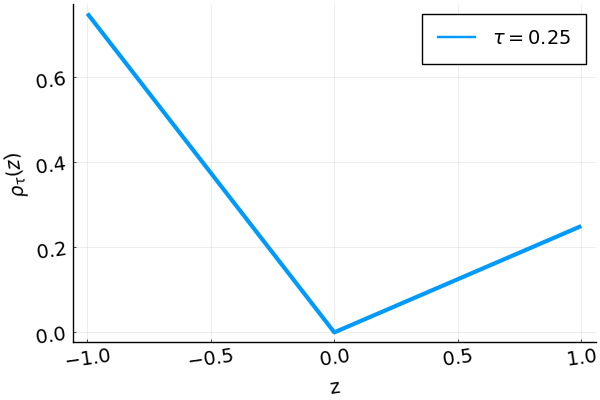

In [10]:
p = plotcheckloss(0.25)

* -ve residuals upweighted by $1-\tau = 0.75$.
* +ve residuals downweighted by $\tau = 0.25$

### Quantile regression as a linear programme

An equivalent way to write the tilted loss function (check) is
$$
\rho_\tau(z) = \tau\, \max(z, 0) + (1-\tau)\,\max(-z,0).
$$

Write the residuals as
$$ y_i - \beta_0 - \beta_1\,x_i = u_i^+ - u_i^-$$
where 
$$
\begin{align*}
u^+_i  &= \max(y_i - \beta_0 - \beta_1\,x_i,\,0) \geq 0\\
u^-_i & = \max(\beta_0 + \beta_1\,x_i-y_i,\,0) \geq 0.
\end{align*}
$$
We then have

$$
\rho_\tau(y_i - \beta_0 - \beta_1\,x_i) = \tau u_i^+ + (1-\tau)\,u_i^-
$$


### Quantile regression as a linear programme

The quantile regression optimisation problem is then equivalent to the LP:
$$
\min_{\beta_0, \beta_1, u^\pm_1\ldots u^\pm_n} \sum_{i=1}^n \tau u_i^+ + (1-\tau)\,u_i^-
$$
subject to the $n$ constraints
$$
u_i^+ - u_i^- = y_i - \beta_0 - \beta_1\,x_i  \ \ \ \ \ \ \ \text{for } i=1\ldots n,
$$
and the positivity conditions 
$$
u_i^+\geq 0,\ \  u_i^- \geq 0  \ \ \ \ \ \ \ \text{for } i=1\ldots n.
$$

To put in standard form, also need to write
$$ 
\beta_0 = \beta_0^+ + \beta_0^- \ \ \ \text{and}\ \ \ 
\beta_1 = \beta_1^+ + \beta_1^-
$$
with $\beta_0^+ \geq 0$, $\beta_0^- \geq 0$, $\beta_1^+ \geq 0$, $\beta_1^- \geq 0$.